## Imports

In [6]:
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

import time
import os

from tempfile import TemporaryDirectory

In [7]:
# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


## Load data

In [36]:
class LabeledData(Dataset):
    def __init__(self, annotation_file, transform=None) -> None:
        self._annotations = pd.read_csv(annotation_file)
        self.labels = self._annotations["label"]
        self.images_path = self._annotations["sample"]
        self.transform = transform

    def __getitem__(self, idx):
        _path_to_image = os.path.join(DATA_PATH, self.images_path[idx])
        image = read_image(_path_to_image)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images_path)


class UnlabeledDate:
    def __init__(self) -> None:
        raise NotImplementedError

In [37]:
DATA_PATH = os.path.join(os.getcwd(), "data")

TASK1_PATH = os.path.join(DATA_PATH, "task1")
TRAIN_TASK1 = os.path.join(TASK1_PATH, "train_data","annotations.csv")
VAL_TASK1 = os.path.join(TASK1_PATH, "val_data")

TASK2_PATH = os.path.join(DATA_PATH, "task2")
TRAIN_TASK2 = os.path.join(TASK2_PATH, "train_data","annotations.csv")
VAL_TASK2 = os.path.join(TASK2_PATH, "val_data")

In [38]:
train_dataset = LabeledData(TRAIN_TASK1)

In [40]:
dataloaders = DataLoader(train_dataset, batch_size=4, shuffle=True)

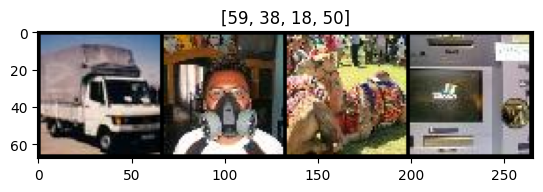

In [55]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    # plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x.item() for x in classes])

In [14]:
ann = pd.read_csv(TRAIN_TASK1)

In [15]:
ann

,sample,label
0,task1/train_data/images/labeled/0.jpeg,0
1,task1/train_data/images/labeled/1.jpeg,1
2,task1/train_data/images/labeled/2.jpeg,2
3,task1/train_data/images/labeled/3.jpeg,3
4,task1/train_data/images/labeled/4.jpeg,4
...,...,...
23550,task1/train_data/images/labeled/23550.jpeg,97
23551,task1/train_data/images/labeled/23551.jpeg,28
23552,task1/train_data/images/labeled/23552.jpeg,53
23553,task1/train_data/images/labeled/23553.jpeg,9


## Base model resnet50

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                # deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [1]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 100)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25
)

In [ ]:
visualize_model(model_ft)